# Chapter 7 code for Julia for Machine Learning book

(c) 2020 by Zacharias Voulgaris, all rights reserved.

This code has been tested for Julia 1.4.1. 

# Initialization

### Packages and relevant script

In [1]:
using CSV, DataFrames;

In [2]:
using StatsBase, Statistics;

In [3]:
using Plots;

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [4]:
using ROC;

┌ Info: Precompiling ROC [e4f92426-8875-4712-a903-a153c75bec82]
└ @ Base loading.jl:1260


In [5]:
using Random;

In [6]:
include("fknn.jl");

### Parameters for this project

In [7]:
K = 5; # K-fold cross validation
k = 4; # number of neighbors
m = 3; # m parameter of fknn model

Note: if you got an alarming large area of red in the outputs of these commands, don't panic. Most of these are just warnings that most likely won't affect the experience of using these packages. Also, the first time you run these packages it is bound to take more time than other times.
 

### Auxiliary functions for model evaluation

In [8]:
function F1_score(yy::Array{Int64, 1}, y::Array{Int64, 1})
    TP = sum((yy .== 1) .== (y .== 1))
    if TP == 0; return 0.0; end
    FP = sum((yy .== 1) .& (y .== 0))
    FN = sum((yy .== 0) .& (y .== 1))
    P = 1 / (1 + FP / TP)
    R = 1 / (1 + FN / TP)
    return 2*P*R/(P + R)
end

F1_score (generic function with 1 method)

In [9]:
# a function for merging the predictions of a model with its confidence to create a variable that can be used with the roc() function
function CombinePredictionsWithConfidence(yy::Array{Int64, 1}, c::Array{Float64, 1}, n::Int64 = length(yy))
    yc = Array{Float64}(undef, n)

    for i = 1:n
        if yy[i] .== 1
            yc[i] = c[i]
        else
            yc[i] = 1.0 - c[i]
        end
    end
    
    return yc
end

CombinePredictionsWithConfidence (generic function with 2 methods)

# Load data from winequality-all.csv file and create new target variable

In [10]:
data = Matrix(CSV.read("winequality-all.csv"; delim=';', header = true));

In [11]:
data[1:10,:]

10×12 Array{Float64,2}:
 7.0  0.27  0.36  20.7  0.045  45.0  170.0  1.001   3.0   0.45   8.8  6.0
 6.3  0.3   0.34   1.6  0.049  14.0  132.0  0.994   3.3   0.49   9.5  6.0
 8.1  0.28  0.4    6.9  0.05   30.0   97.0  0.9951  3.26  0.44  10.1  6.0
 7.2  0.23  0.32   8.5  0.058  47.0  186.0  0.9956  3.19  0.4    9.9  6.0
 7.2  0.23  0.32   8.5  0.058  47.0  186.0  0.9956  3.19  0.4    9.9  6.0
 8.1  0.28  0.4    6.9  0.05   30.0   97.0  0.9951  3.26  0.44  10.1  6.0
 6.2  0.32  0.16   7.0  0.045  30.0  136.0  0.9949  3.18  0.47   9.6  6.0
 7.0  0.27  0.36  20.7  0.045  45.0  170.0  1.001   3.0   0.45   8.8  6.0
 6.3  0.3   0.34   1.6  0.049  14.0  132.0  0.994   3.3   0.49   9.5  6.0
 8.1  0.22  0.43   1.5  0.044  28.0  129.0  0.9938  3.22  0.45  11.0  6.0

In [12]:
N, nf = size(data) # number of data points and features

(6497, 12)

In [13]:
nf -= 1; # don't count the target variable

In [14]:
X = data[:, 1:nf];

In [15]:
temp = data[:,end];

In [16]:
y = Int64.(temp .> 5.8); # 5.8 is the average value of the target variable

In [17]:
unique(y)

2-element Array{Int64,1}:
 1
 0

# Work the data using StatsBase package

In [18]:
mean(X, dims=1)

1×11 Array{Float64,2}:
 7.21531  0.339666  0.318633  5.44324  …  0.994697  3.2185  0.531268  10.4918

In [19]:
std(X, dims=1)

1×11 Array{Float64,2}:
 1.29643  0.164636  0.145318  4.7578  …  0.160787  0.148806  1.19271

In [20]:
X_norm = Array{Float64}(undef, N, nf);

In [23]:
for i = 1:nf
    dt = StatsBase.fit(ZScoreTransform, X[:,i], dims=1); # normalization model
    X_norm[:,i] = StatsBase.transform(dt, X[:,i])
end

In [24]:
mean(X_norm, dims=1)

1×11 Array{Float64,2}:
 3.06221e-16  -2.44977e-16  5.24951e-17  0.0  …  2.44977e-16  9.53661e-16

In [25]:
std(X_norm, dims=1)

1×11 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [26]:
X_norm[1:10,:]

10×11 Array{Float64,2}:
 -0.166076   -0.42315    0.284664    …  -1.35894     -0.546136  -1.41845
 -0.706019   -0.240931   0.147035        0.506876    -0.27733   -0.831551
  0.682405   -0.362411   0.559923        0.2581      -0.613338  -0.328496
 -0.0118071  -0.66611    0.00940548     -0.177258    -0.882144  -0.496181
 -0.0118071  -0.66611    0.00940548     -0.177258    -0.882144  -0.496181
  0.682405   -0.362411   0.559923    …   0.2581      -0.613338  -0.328496
 -0.783154   -0.119451  -1.09163        -0.239452    -0.411733  -0.747709
 -0.166076   -0.42315    0.284664       -1.35894     -0.546136  -1.41845
 -0.706019   -0.240931   0.147035        0.506876    -0.27733   -0.831551
  0.682405   -0.72685    0.766367        0.00932384  -0.546136   0.426087

# Data Engineering

## Feature Selection

In [27]:
ind = setdiff((1:11), [7,8]) # features to keep

9-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  9
 10
 11

In [28]:
nf -= 2

9

In [29]:
XX = X_norm[:, ind]; # final version of the featureset

# Work the data using the FKNN model

### Training and Testing split

In [30]:
split_ratio = 0.8;

In [31]:
indexes = randperm(N);

In [32]:
N_training = round(Int64, split_ratio * N); # number of data points in training set

In [33]:
N_testing = N - N_training;

In [34]:
train = indexes[1:N_training];

In [35]:
test = indexes[(N_training+1):end];

In [36]:
X_train, y_train = XX[train,:], y[train];

In [37]:
X_test, y_test = XX[test,:], y[test];

### K-fold split (for K-fold cross-validation)

In [38]:
n = div(N, K) # number of data points in each partition

1299

In [39]:
X_random = XX[indexes,:];
y_random = y[indexes];

In [40]:
P = Array{Any}(undef, K) # partitions array

5-element Array{Any,1}:
 #undef
 #undef
 #undef
 #undef
 #undef

In [41]:
a = 1;
b = n;

for i = 1:(K-1)
    P[i] = Array{Any}(undef, 2)
    P[i][1] = X_random[a:b,:]
    P[i][2] = y_random[a:b]
    a += n
    b += n
end

P[K] = Array{Any}(undef, 2)
P[K][1] = X_random[a:end,:]
P[K][2] = y_random[a:end];

In [42]:
P

5-element Array{Any,1}:
 Any[[1.8394252084641307 1.581265644537156 … 0.26028355865660563 -0.6638660446686709; 0.296731655502188 0.4272078875526628 … 0.7306950975273647 -1.1669213726370191; … ; -0.1660764103863945 -1.1520290430576963 … -0.949346112725345 -1.2507639272984103; -0.5517497986268801 0.3057281236595585 … -1.2181527063657787 -0.412338380684496], [0, 0, 0, 1, 0, 1, 1, 0, 0, 0  …  1, 1, 0, 1, 1, 0, 0, 0, 1, 0]]
 Any[[-1.708769963348337 4.253820450185457 … 0.5962918007071478 0.8452999392363754; -0.24321108803449137 -0.36241057775251645 … -1.0165477611354534 1.5160403765275074; … ; 0.7595397213907705 0.06276859587334917 … 1.8731231204992076 0.42608716592941825; -0.24321108803449137 -0.36241057775251645 … -1.3525560031859953 -0.24465327136171378], [0, 1, 1, 0, 0, 0, 0, 1, 1, 1  …  0, 1, 0, 0, 1, 1, 1, 1, 1, 0]]
 Any[[-0.9374231868673658 -0.9090695152714872 … -0.008523034983827425 0.6776148299135931; 0.1424623002059943 1.4597858806440513 … 0.3274852070667141 0.6776148299135931; … ; 

In [43]:
for i = 1:K
    println(size(P[i][1], 1), " ", length(P[i][2])) # sizes of each partition: features & target variable
end 

1299 1299
1299 1299
1299 1299
1299 1299
1301 1301


## Classification model

### Simple training-testing case

In [44]:
M, Q, mc = fknn_train(X_train, y_train, k, m)

([1.0 0.0; 1.0 0.0; … ; 0.25 0.75; 1.0 0.0], [0, 1], 2)

In [45]:
yy, c = fknn_apply(X_test, X_train, k, M, Q, mc, m);

In [46]:
sum(yy .== y_test) / N_testing # accuracy rate

0.6759045419553503

In [47]:
F1 = F1_score(yy, y_test)

0.8066146072576941

In [48]:
mean(c)

0.8860676410704771

### ROC Analysis

In [49]:
y_with_c = CombinePredictionsWithConfidence(yy, c)

1299-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 0.5408190188750022
 1.0
 0.0
 1.0
 0.0
 0.12096624527565603
 1.0
 0.5079139860512338
 1.0
 ⋮
 0.75
 0.316996071505639
 0.0
 0.5296647824501646
 0.7814899742238033
 1.0
 1.0
 1.0
 0.5
 1.0
 1.0
 0.8718085890870135

In [50]:
roc_data = roc(y_with_c, y_test, true);

In [51]:
AUC(roc_data)

0.6598192888806603

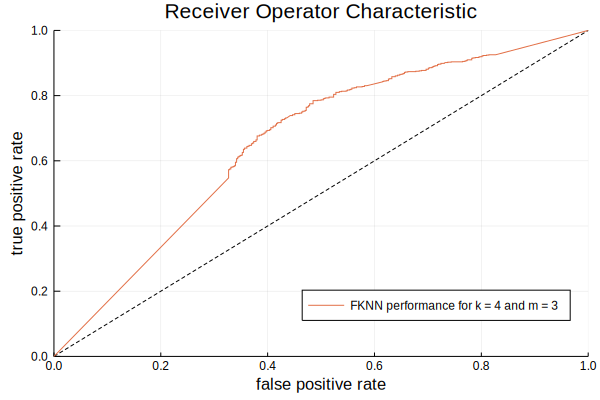

In [52]:
plot(roc_data, label = string("FKNN performance for k = ", k, " and m = ", m), legend = :bottomright)

### K-fold Cross Validation

In [53]:
F1 = Array{Float64}(undef, K)

for i = 1:K
    ind = setdiff((1:K), i)
    
    X_train = P[ind[1]][1]
    y_train = P[ind[1]][2]
    
    for j = 2:(K-1)
        X_train = vcat(X_train, P[ind[j]][1])
        y_train = vcat(y_train, P[ind[j]][2])
    end
    
    X_test = P[i][1]
    y_test = P[i][2]
    
    M, Q, mc = fknn_train(X_train, y_train, k, m)
    yy = fknn_apply(X_test, X_train, k, M, Q, mc, m)[1]
    
    F1[i] = F1_score(yy, y_test)
end

In [54]:
min_F1, max_F1 = extrema(F1)
println(F1, "\n", mean(F1), "\n", min_F1, " ", max_F1)

[0.8153214774281805, 0.8055172413793104, 0.8201634877384195, 0.8318345323741008, 0.8075160403299725]
0.8160705558499968
0.8055172413793104 0.8318345323741008


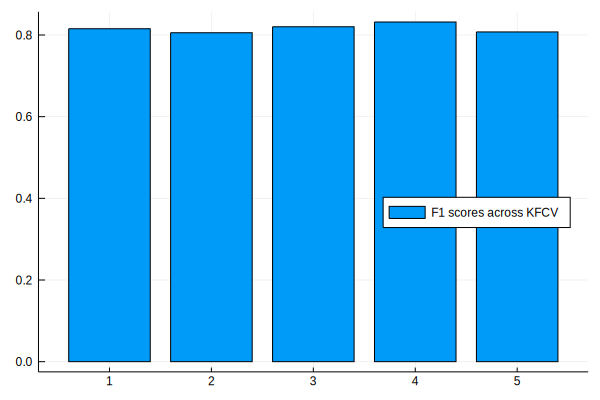

In [55]:
bar(F1, label = "F1 scores across KFCV", legend = :right)

# Conclusions

The FKNN model although it meets all the requirements for the project, is still not ideal for this dataset. Its accuracy rate is average, just like its Area Under Curve score. However, the F1 score for class 1 (good wines) is decent. So, if we were to use this model primarily to predict if a wine is good, it's an acceptable option.

Despite its average performance, this FKNN model is quite stable, something that's evident from the 5-fold cross validation conducted. So, if its performance is acceptable by the project stakeholders, it is reliable enough to deploy.

# Sandbox

A place for you to experiment with the above dataset and methods, without making a mess of the whole notebook or disrupt its flow. It's much easier to maintain this section than keep track of various copies of this notebook.